Best Inlier Count = 734
Best Inlier Count = 544
Best Inlier Count = 695
Best Inlier Count = 493
Estimated Homography Matrix
[[ 6.11404459e-01  5.03189502e-02  2.21391678e+02]
 [ 2.11980223e-01  1.14096503e+00 -2.14952739e+01]
 [ 4.74861344e-04 -5.18621014e-05  9.90604809e-01]]

Ground Truth Homography Matrix
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]

Sum of Squared Errors: 17.280918220854026


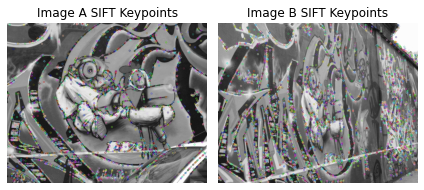

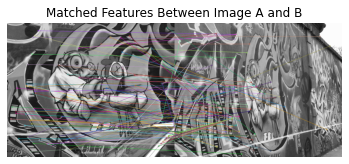

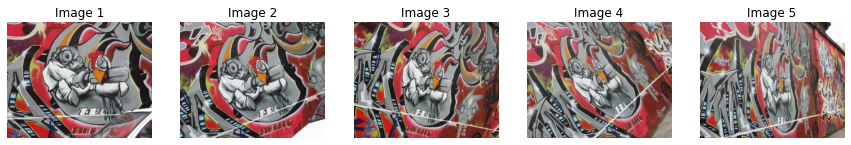

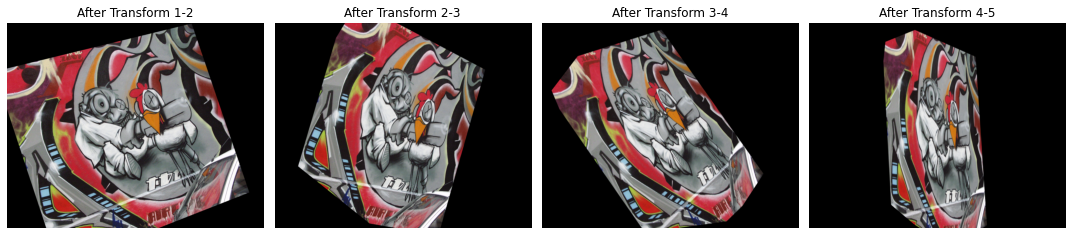

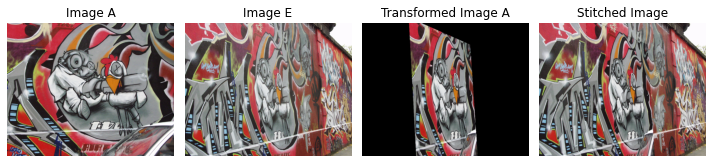

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def extract_SIFT_keypoints(imgA, imgB, display=False):
    # Detect and match SIFT features between two images
    gray_imgA = cv.cvtColor(imgA, cv.COLOR_RGB2GRAY)
    gray_imgB = cv.cvtColor(imgB, cv.COLOR_RGB2GRAY)

    # Initiate SIFT detector
    sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=25, sigma=1)

    # Find key points and descriptors
    kpA, descA = sift.detectAndCompute(gray_imgA, None)
    kpB, descB = sift.detectAndCompute(gray_imgB, None)

    # Match features using BFMatcher
    matcher = cv.BFMatcher()
    matches = matcher.knnMatch(descA, descB, k=2)

    # Apply ratio test to select good matches
    filtered_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            filtered_matches.append(m)

    if display:
        plt.figure()
        plt.subplot(1, 2, 1)
        imgA_features = cv.drawKeypoints(gray_imgA, kpA, gray_imgA)
        plt.imshow(imgA_features)
        plt.title("Image A SIFT Keypoints")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        imgB_features = cv.drawKeypoints(gray_imgB, kpB, gray_imgB)
        plt.imshow(imgB_features)
        plt.title("Image B SIFT Keypoints")
        plt.axis('off')
        plt.tight_layout()

        plt.figure()
        matched_img = cv.drawMatches(gray_imgA, kpA, gray_imgB, kpB, filtered_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(matched_img)
        plt.title("Matched Features Between Image A and B")
        plt.axis('off')

    return filtered_matches, kpA, kpB

def calculate_inliers(src_pts, dest_pts, homography_matrix, threshold):
    # Compute errors to find inliers
    dest_estimates = homography_matrix(src_pts)
    errors = np.sqrt(np.sum(np.square(dest_estimates - dest_pts), axis=1))

    return np.where(errors < threshold)[0]

def estimate_homography(good_matches, kpA, kpB):
    # Collect matching points into arrays
    src_pts = []
    dest_pts = []

    for match in good_matches:
        src_pts.append(np.array(kpA[match.queryIdx].pt))
        dest_pts.append(np.array(kpB[match.trainIdx].pt))

    src_pts = np.array(src_pts)
    dest_pts = np.array(dest_pts)

    # RANSAC to find the optimal homography
    points_needed = 4
    error_threshold = 1
    min_inliers = 0.5 * len(good_matches)
    max_iters = 200

    optimal_homography = None
    max_inliers = 0
    best_inliers = None

    for _ in range(max_iters):
        chosen_matches = np.random.choice(good_matches, points_needed, replace=False)

        src_points_sample = []
        dest_points_sample = []
        for match in chosen_matches:
            src_points_sample.append(np.array(kpA[match.queryIdx].pt))
            dest_points_sample.append(np.array(kpB[match.trainIdx].pt))

        src_points_sample = np.array(src_points_sample)
        dest_points_sample = np.array(dest_points_sample)

        homography_estimate = transform.estimate_transform('projective', src_points_sample, dest_points_sample)
        inliers = calculate_inliers(src_pts, dest_pts, homography_estimate, error_threshold)

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            optimal_homography = homography_estimate
            best_inliers = inliers

    print(f'Best Inlier Count = {max_inliers}')
    return optimal_homography, best_inliers

from skimage import transform

# Load images
imgA = cv.imread("Resources/graf/img1.ppm")
imgA = cv.cvtColor(imgA, cv.COLOR_BGR2RGB)

imgB = cv.imread("Resources/graf/img5.ppm")
imgB = cv.cvtColor(imgB, cv.COLOR_BGR2RGB)

matches, keypoints_A, keypoints_B = extract_SIFT_keypoints(imgA, imgB, display=True)

np.random.seed(62)
extra_padding = 100

image_set = []
plt.figure(figsize=(15, 10))
for i in range(1, 6):
    image = cv.imread(f"Resources/graf/img{i}.ppm")
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_set.append(image)
    plt.subplot(1, 5, i)
    plt.imshow(image)
    plt.title(f"Image {i}")
    plt.axis('off')

combined_transform = transform.ProjectiveTransform(np.identity(3))

transformed_img = image_set[0]

plt.figure(figsize=(15, 10))
for i in range(1, 5):
    imgA, imgB = image_set[i-1], image_set[i]
    good_matches, kpA, kpB = extract_SIFT_keypoints(imgA, imgB)
    homography_matrix, _ = estimate_homography(good_matches, kpA, kpB)
    transformed_img = transform.warp(transformed_img, homography_matrix.inverse)
    combined_transform = combined_transform + homography_matrix
    plt.subplot(1, 4, i)
    plt.imshow(transformed_img)
    plt.title(f"After Transform {i}-{i+1}")
    plt.axis('off')

plt.tight_layout()
final_output = transform.warp(image_set[0], combined_transform.inverse)

# Blend transformed image with last image
final_output = (final_output * 255).astype(np.uint8)
mask = (final_output == 0)
stitched_image = mask * image_set[4] + final_output

# Plotting results
plt.figure(figsize=(10, 10))

plt.subplot(1, 4, 1)
plt.imshow(image_set[0])
plt.title("Image A")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(image_set[4])
plt.title("Image E")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(final_output)
plt.title("Transformed Image A")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')
plt.tight_layout()

# Ground truth homography for comparison
true_homography = np.array([[6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
                            [2.2240536e-01, 1.1652147e+00, -2.5605611e+01],
                            [4.9212545e-04, -3.6542424e-05, 1.0000000e+00]])

print("Estimated Homography Matrix")
print(combined_transform.params)
print()
print("Ground Truth Homography Matrix")
print(true_homography)
print()

# Calculate squared errors between ground truth and estimated homography
print("Sum of Squared Errors:", np.sum(np.square(true_homography - combined_transform.params)))